In [2]:
# pip install ipython
# pip install pillow
# pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
# pip install xgboost
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from PIL import Image as Image2

import tushare as ts
import datetime
from datetime import datetime as dtime
import mpl_finance as mpf
import seaborn as sns
from matplotlib.pylab import date2num
import talib

from xgboost import XGBClassifier
from xgboost import XGBRegressor

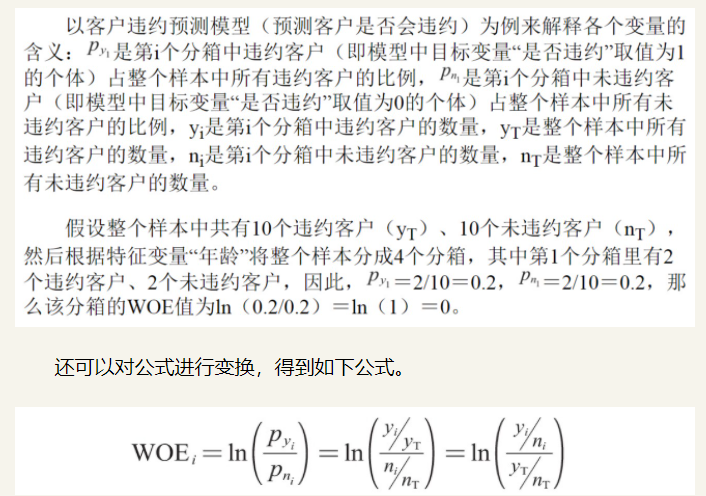

In [6]:
'''
拟合训练前需要通过特征的 预测能力、简单性、可解释性等 来选择入模特征

WOE value 与 IV value 可以被用来衡量特征变量的预测能力(分类模型中的区分度)

类似的被用来衡量特征变量的预测能力的值还有 基尼系数 与信息增益

分箱 -> WOE -> IV
'''

# 某特征在分箱内的 WOE(weight_of_evidence)绝对值越大说明其区分度越大(分类效果更好)
Image(filename = "woe.png", width = 500, height = 500)

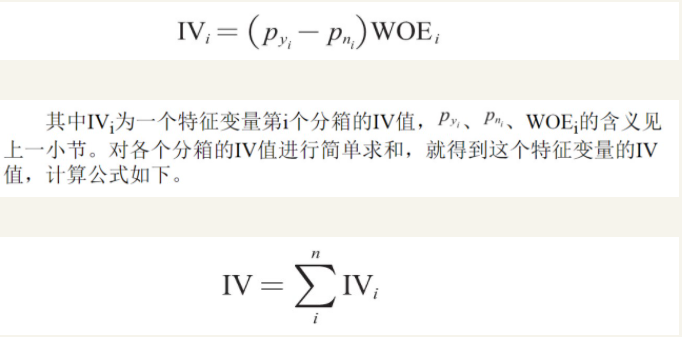

In [10]:
# IV(information_value)值越大，代表该特征对预测结果的贡献越大。
# 设有 n个箱子
# 相较于 WOE的优点: 永远非负,权重因子可以体现分箱的样本量占整体的比例
Image(filename = "iv.png", width = 500, height = 500)

In [11]:
# 代码实现
data = pd.DataFrame([[22,1],[25,1],[20,0],[35,0],[32,1],[38,0],\
                     [50,0],[46,1]], columns=['年龄', '是否违约'])
data

,年龄,是否违约
0,22,1
1,25,1
2,20,0
3,35,0
4,32,1
5,38,0
6,50,0
7,46,1


In [12]:
# 有了数据之后，根据“年龄”这一特征变量进行数据分箱，代码如下：
data_cut = pd.cut(data['年龄'], 3)
data_cut

0    (19.97, 30.0]
1    (19.97, 30.0]
2    (19.97, 30.0]
3     (30.0, 40.0]
4     (30.0, 40.0]
5     (30.0, 40.0]
6     (40.0, 50.0]
7     (40.0, 50.0]
Name: 年龄, dtype: category
Categories (3, interval[float64]): [(19.97, 30.0] < (30.0, 40.0] < (40.0, 50.0]]

In [17]:
# 统计总客户数
cut_group_all = data['是否违约'].groupby(data_cut).count()
# 统计违约客户
cut_y = data['是否违约'].groupby(data_cut).sum() #1+0+1 = 2
# 统计未违约客户
cut_n = cut_group_all - cut_y

cut_group_all

年龄
(19.97, 30.0]    3
(30.0, 40.0]     3
(40.0, 50.0]     2
Name: 是否违约, dtype: int64

In [18]:
df = pd.DataFrame()  # 创建一个空DataFrame用来汇总数据
df['总数'] = cut_group_all
df['坏样本'] = cut_y
df['好样本'] = cut_n
df

,总数,坏样本,好样本
年龄,,,
"(19.97, 30.0]",3,2,1
"(30.0, 40.0]",3,1,2
"(40.0, 50.0]",2,1,1


In [19]:
# 计算坏样本%和好样本%
df['坏样本%'] = df['坏样本'] / df['坏样本'].sum()
df['好样本%'] = df['好样本'] / df['好样本'].sum()
df

,总数,坏样本,好样本,坏样本%,好样本%
年龄,,,,,
"(19.97, 30.0]",3,2,1,0.50,0.25
"(30.0, 40.0]",3,1,2,0.25,0.50
"(40.0, 50.0]",2,1,1,0.25,0.25


In [20]:
df['WOE'] = np.log(df['坏样本%'] / df['好样本%'])
df

,总数,坏样本,好样本,坏样本%,好样本%,WOE
年龄,,,,,,
"(19.97, 30.0]",3,2,1,0.50,0.25,0.693147
"(30.0, 40.0]",3,1,2,0.25,0.50,-0.693147
"(40.0, 50.0]",2,1,1,0.25,0.25,0.000000


In [22]:
#在实际应用中，我们不希望WOE值出现无穷大:
#这样会导致之后计算的IV值也变为无穷大，丧失了IV值的意义
#解决办法是当WOE值为无穷大时，将它替换为0.

df = df.replace({'WOE': {np.inf: 0, -np.inf: 0}})

#calculate IV value
df['IV'] = df['WOE'] * (df['坏样本%'] - df['好样本%'])
df

,总数,坏样本,好样本,坏样本%,好样本%,WOE,IV
年龄,,,,,,,
"(19.97, 30.0]",3,2,1,0.50,0.25,0.693147,0.173287
"(30.0, 40.0]",3,1,2,0.25,0.50,-0.693147,0.173287
"(40.0, 50.0]",2,1,1,0.25,0.25,0.000000,0.000000


In [23]:
# 求全局 iv值
iv = df['IV'].sum()
print(iv)

0.34657359027997264


In [24]:
# 重写，定义函数

def cal_iv(data, cut_num, feature, target):
    # 1.数据分箱
    data_cut = pd.cut(data[feature], cut_num)

    # 2.统计各个分箱样本总数、坏样本数和好样本数
    cut_group_all = data[target].groupby(data_cut).count()  # 总客户数
    cut_y = data[target].groupby(data_cut).sum()  # 坏样本数
    cut_n = cut_group_all - cut_y  # 好样本数
    # 汇总基础数据
    df = pd.DataFrame()  # 创建一个空DataFrame用来汇总数据
    df['总数'] = cut_group_all
    df['坏样本'] = cut_y
    df['好样本'] = cut_n

    # 3.统计坏样本%和好样本%
    df['坏样本%'] = df['坏样本'] / df['坏样本'].sum()
    df['好样本%'] = df['好样本'] / df['好样本'].sum()

    # 4.计算WOE值
    df['WOE'] = np.log(df['坏样本%'] / df['好样本%'])
    df = df.replace({'WOE': {np.inf: 0, -np.inf: 0}}) 

    # 5.计算各个分箱的IV值
    df['IV'] = df['WOE'] * (df['坏样本%'] - df['好样本%'])

    # 6.汇总各个分箱的IV值，获得特征变量的IV值
    iv = df['IV'].sum()
    
    print(iv)

In [25]:
rl_data = pd.read_excel('股票客户流失.xlsx')
rl_data.head()

,账户资金（元）,最后一次交易距今时间（天）,上月交易佣金（元）,累计交易佣金（元）,本券商使用时长（年）,是否流失
0,22686.5,297,149.25,2029.85,0,0
1,190055.0,42,284.75,3889.50,2,0
2,29733.5,233,269.25,2108.15,0,1
3,185667.5,44,211.50,3840.75,3,0
4,33648.5,213,353.50,2151.65,0,1


In [26]:
cal_iv(rl_data, 4, '账户资金（元）', '是否流失')

0.15131562165200105


In [27]:
for i in rl_data.columns[:-1]:
    print(i + '的IV值为：')
    cal_iv(rl_data, 4, i, '是否流失')

账户资金（元）的IV值为：
0.15131562165200105
最后一次交易距今时间（天）的IV值为：
0.2535183073507812
上月交易佣金（元）的IV值为：
0.3069923220629877
累计交易佣金（元）的IV值为：
0.15131562165200105
本券商使用时长（年）的IV值为：
0.6146141736785371
